In [32]:

import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heartdisease/heart_test.csv
/kaggle/input/heartdisease/heart_train.csv
/kaggle/input/heartdisease/heart_sample_submission.csv


# 1. Read data from csv files

In [110]:
# Read the data
X_full = pd.read_csv('/kaggle/input/heartdisease/heart_train.csv', index_col = ['id'])
X_test = pd.read_csv('/kaggle/input/heartdisease/heart_test.csv', index_col = ['id'])
X_full.dropna(axis=0, subset=['HeartDisease'], inplace=True)
y = X_full['HeartDisease']
X_full.drop(labels=['HeartDisease'], axis=1, inplace=True)

categorical_cols = [col for col in X_full if X_full[col].nunique() < 10 and X_full[col].dtype=='object']
numerical_cols = [col for col in X_full if X_full[col].dtype=='int64' or X_full[col].dtype=='float64']

# 2. Examine data
### 2.1 Data overview
Take an overview of what is the data look like

In [34]:
X_full.head()

,Unnamed: 0,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
id,,,,,,,,,,,,
0,0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,2,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up


In [35]:
X_full.dtypes

Unnamed: 0          int64
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
dtype: object

In [36]:
print(numerical_cols)
X_full[numerical_cols].describe()

['Unnamed: 0', 'Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']


,Unnamed: 0,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000,643.000000
mean,321.000000,53.356143,132.359253,197.657854,0.225505,136.824261,0.887869
std,185.762393,9.428155,18.997459,107.527746,0.418240,25.824025,1.070916
min,0.000000,29.000000,0.000000,0.000000,0.000000,67.000000,-2.600000
25%,160.500000,47.000000,120.000000,175.000000,0.000000,118.500000,0.000000
50%,321.000000,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000
75%,481.500000,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000
max,642.000000,77.000000,200.000000,529.000000,1.000000,202.000000,5.600000


### 2.2 Target distribution


We notice that the data is divided balancely for case not having and having a heart disease with around **42.2%** and **55.8%** respectively. Which gives us a confidence that there is no imbalance in this data.

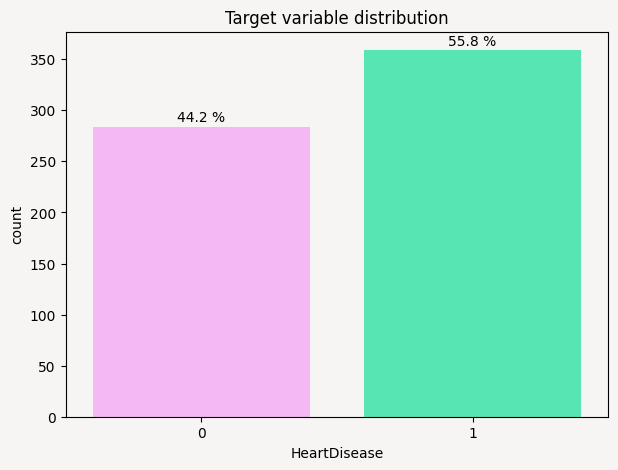

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns


mypal= ['#FC05FB', '#FEAEFE', '#FCD2FC','#F3FEFA', '#B4FFE4','#3FFEBA']
plt.figure(figsize=(7,5), facecolor='#F6F5F4')
total = int(len(X_full))
ax = sns.countplot(x=y, palette=mypal[1::4])
ax.set_facecolor('#F6F5F4')
ax.set_title('Target variable distribution')
for col in ax.patches:
    height = col.get_height()
    width = col.get_width()
    curX = col.get_x()
    ax.text(curX + width/2, height + 5, '{:.1f} %'.format((height/total) * 100), ha="center")

# 3. Data cleaning & Features engineering
As we saw in the data exploring section, there are 3 distinct data type i.e **object**, **int64** and **float64**. So I will group them according to their data type. Specifically, **object** in categorical group, **int64** and **float64** in numerical group.

In [111]:
# Get ready for one-hot encoding 
chosen_cols = categorical_cols + numerical_cols
X_full=X_full[chosen_cols].copy()
X_test=X_test[chosen_cols].copy()

# Split training and validity test
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, test_size=0.2, train_size=0.8, random_state=0)

# 4. Build model
Scikit learn offers a wide range of classification algorithms. In this machine learning challenge, I will start by exploring a few of classification algorithm that is available in sklearn library such as `Logistic Regression`, `Nearest Neighbors`, `Support Vectors`, `Nu SVC`, `Decision Tree`, `Random Forest`, `AdaBoost`, `Gradient Boosting`, `Naive Bayes`, `Linear Discriminant Analysis`, `Quadratic Discriminant Analysis`, `Neural Net` and `XGBoost`

In [112]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

# Import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import recall_score, accuracy_score, auc

In [113]:
def create_model(classifier):
    '''
    This function take a classifier 'classifier', then return a Pipeline that preprocess the data and 
    classify using 'classifier'
    '''
    numerical_transformer = SimpleImputer(strategy='mean')
    categorical_transformer = Pipeline(steps=[
        ('imp1', SimpleImputer(strategy='most_frequent')),
        ('encoding', OneHotEncoder(handle_unknown='ignore')),
        ('imp2', SimpleImputer(strategy='median')),
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols),
    ])
    pip = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', classifier)
    ])
    return pip

def evaluate(y_valid, pred):
    acc = (len(y_valid) - np.sum(pred != y_valid)) / len(y_valid) * 100
    cm = confusion_matrix(y_valid, pred)
    # Question: Where did i make mistake in the comparision numpy array
    prec = cm[1,1] / (cm[1, 1] + cm[1, 0]) * 100
    recall = cm[1, 1] / (cm[1, 1] + cm[0, 1]) * 100
    f1 = 2 * prec * recall / (prec + recall)
    
    return acc, prec, recall, f1
    
def fit_models(names, classifiers):
    '''
    Given a list of classifiers, this function calculates the accuracy, recall and return the
    result in a data frame
    '''
    cols = ['Classifier', 'Accuracy', 'Recall', 'Precision', 'F1']
    res = pd.DataFrame(columns = cols)
    for name, classifier in zip(names, classifiers):
        model = create_model(classifier)
        model.fit(X_train, y_train)
        pred = model.predict(X_valid)
        acc, prec, recall, f1 = evaluate(y_valid, pred)
        new_row = pd.DataFrame([[name, acc, recall, prec, f1]], columns = cols)
        res = pd.concat([res, new_row], ignore_index=True)
    return res

def plot_conf_matrix(names, classifiers):
    '''
    Given a list of names and classifiers, plot a confusion matrix for each classifier in 'classifiers'
    '''
    for name, classifier in zip(names, classifiers):
        model = create_model(classifier)
        model.fit(X_train, y_train)
        pred = model.predict(X_valid)
        cm = confusion_matrix(y_valid, pred)
        
        

def plot_roc_curves(names, classifiers):
    ''''
    Given a list of names and classifiers, plot the ROC curve of each model in 'classifiers'
    '''
    plt.figure(figsize=(12,8))
    for name, classifier in zip(names, classifiers):
        model = create_model(classifier)
        model.fit(X_train, y_train)
        pred_prob = model.predict_proba(X_valid)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_valid, pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label=name + 'ROC curve (area = {:.2f})'.format(roc_auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.plot([0, 1], [0, 1], linestyle='--', color="navy")
        plt.title('Receiver operating characteristic (ROC) curves', fontsize=20)
        plt.legend(loc="lower right")

### 4.1.1 Performance metric
There are several metrics that can be used to gauge the performance of a given classification. Since we are dealing with medical case (classify a case is positive for heart disease or not), so recall (true positive rate or sensitivity) is more likely to be used than precision as our performance metrics. Since we are concerning more about the proportion of patients get predicted correctly rather than the percentage of patients actually have a heart disease among all of those get predicted to have it.

**Confusion matrix**: A confusion matrix is a specific table layout that allows visualization of the performance of a supervised learning algorithm. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class.

![Sample Image](https://miro.medium.com/v2/resize:fit:400/1*LQ1YMKBlbDhH9K6Ujz8QTw.jpeg)

---

**Key**: 

|**Term** |**Meaning** | **Descriptions**| 
| --- |---|---|
|TP |True Positive|Positive cases which are predicted as positive|
|FP |False Positive|Negative cases which are predicted as positive|
|TN |True Negative|Negative cases which are predicted as negative|
|FN |False Negative|Positive casea which are predicted as negative|

**Precision**: Measures the porportion of the actual correct cases among all those got predicted positive.

$P = \frac{TP}{TP + FP}$

**Recall**: Measures the porportion of positive cases among all cases that are labeled positive.

$R = \frac{TP}{TP + FN}$

**F1**: Combines the precision and recall of the model and it is defined as the harmonic mean of the model's precision and recall

$F1 = 2\frac{PR}{P + R}$

In [114]:
names = [
    'Logistic Regression',
    'Nearest Neighbors',
    'Support Vectors',
    'Nu SVC',
    'Decision Tree',
    'Random Forest',
    'AdaBoost',
    'Gradient Boosting',
    'Naive Bayes',
    'Linear DA',
    'Quadratic DA',
    'Neural Net'
]
seed = 0
classifiers = [
    LogisticRegression(solver='liblinear', random_state=seed),
    KNeighborsClassifier(2),
    SVC(probability=True, random_state=seed),
    NuSVC(probability=True, random_state=seed),
    DecisionTreeClassifier(random_state=seed),
    RandomForestClassifier(random_state=seed),
    AdaBoostClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(random_state=seed),
]
fit_models(names, classifiers).sort_values(by="Accuracy", ascending=False)

/tmp/ipykernel_33/3492074573.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, new_row], ignore_index=True)
/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,Classifier,Accuracy,Recall,Precision,F1
5,Random Forest,88.372093,87.837838,91.549296,89.655172
0,Logistic Regression,86.821705,87.500000,88.732394,88.111888
7,Gradient Boosting,86.046512,87.323944,87.323944,87.323944
8,Naive Bayes,86.046512,89.552239,84.507042,86.956522
9,Linear DA,86.046512,86.301370,88.732394,87.500000
6,AdaBoost,85.271318,87.142857,85.915493,86.524823
11,Neural Net,83.720930,91.666667,77.464789,83.969466
3,Nu SVC,82.170543,83.333333,84.507042,83.916084
4,Decision Tree,81.395349,86.153846,78.873239,82.352941
2,Support Vectors,71.317829,74.285714,73.239437,73.758865


### 4.1.2 ROC curves
ROC curves : A receiver operating characteristic (ROC) curve, is a graphical plot which illustrates the performance of a binary classification algorithm as a function of ture positive rate and false positive rate.

The area under ROC curve (AUC) is a performance measurements for classification models at various threshold settings. It represents the degree or measure of separability achieved by the model. For example:
- **AUC = 1**: The model has perfect discrimination, meaning it can perfectly distinguish between positive and negative classes.
- **AUC = 0.5**: The model has no discrimination capacity, effectively making random guesses. This is equivalent to the performance of a random classifier.
- **AUC < 0.5**: The model performs worse than random guessing, which implies that it is predicting the positive class as negative and vice versa.

/opt/conda/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


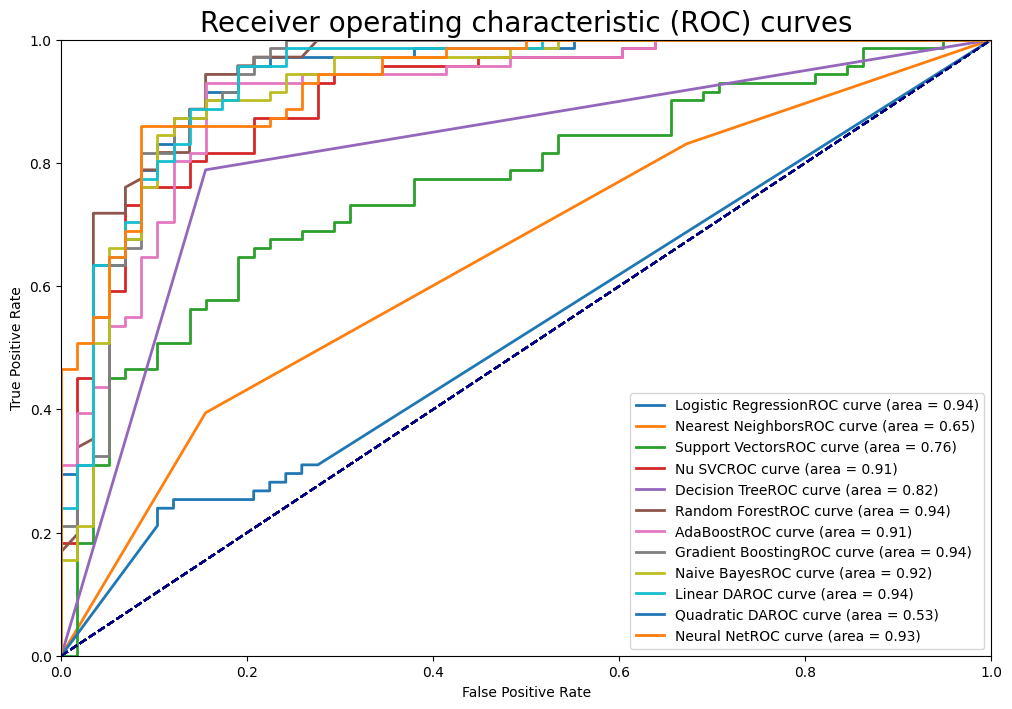

In [115]:
plot_roc_curves(names, classifiers)

As we have seen all the perfomance metrics, now it's time to determine which model is the best possible classifier algorithm. We can easily saw that `RandomForest` dominate in every metrics (highest in all `Accuracy`, `Precision` and `Recall`). Therefore, obviously we will choose `RandomForest` as our classifier algorithm

## 4.2 Hyperparameter tuning

Chosen our best classifier, `RandomForest`. However, this was achieved by default parameter. The intuition is that we could improve our model further with tuned parameters. We can achieve that with Scikit-learn RandomizedSearch algorithm

In [122]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'criterion': criterion,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, None], 'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [123]:
rf = RandomForestClassifier(random_state=seed)
optimizer = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=0, random_state=42, n_jobs = -1, scoring="f1")
model = create_model(optimizer)
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imp1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imp2',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('num', SimpleImputer(),
                                                  ['Unnamed: 0', 'Age',
                                                   'RestingBP',...
                                    estimator=RandomForestClassifier(random_state=0),
                                    n_iter=50, n_jobs=-1,
                                    param_distributions={'bootstrap': [True,
                                                                       False],
                                                         'criterion': ['gini',
                                                                       'entropy',
                                                                       'log_loss'],
                                                         'max_depth': [10, 14,
                                                                       18, 22,
                                                                       26, 30,
                                                                       34, 38,
                                                                       42, 46,
                                                                       50,
                                                                       None],
                                                         'min_samples_leaf': [1,
                                                                              2,
                                                                              4],
                                                         'min_samples_split': [2,
                                                                               5,
                                                                               10],
                                                         'n_estimators': [100,
                                                                          200,
                                                                          300,
                                                                          400,
                                                                          500,
                                                                          600,
                                                                          700,
                                                                          800,
                                                                          900,
                                                                          1000]},
                                    random_state=42, scoring='f1'))])

In [118]:
model.named_steps['model'].best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 40,
 'criterion': 'log_loss',
 'bootstrap': True}

In [119]:
opt_param = model.named_steps['model'].best_params_
rf = create_model(RandomForestClassifier(**opt_param, random_state=seed))
rf.fit(X_train, y_train)
print(classification_report(y_valid, rf.predict(X_valid)))
pred = rf.predict(X_valid)
acc, prec, recall, f1 = evaluate(y_valid, pred)
print("Accuracy:", acc, "Recall:", recall, "Precision:", prec, "F1:", f1)

              precision    recall  f1-score   support

           0       0.89      0.84      0.87        58
           1       0.88      0.92      0.90        71

    accuracy                           0.88       129
   macro avg       0.88      0.88      0.88       129
weighted avg       0.88      0.88      0.88       129

Accuracy: 88.37209302325581 Recall: 87.83783783783784 Precision: 91.54929577464789 F1: 89.6551724137931


**Remark:** It turns out that our base model (default params) is not bad at all. Parameter tuning did not help to further increase the performance.

# 5. Predict
Now we finish building our model, so we will test the model on the test data and submit it on the competition site

In [121]:
pred = rf.predict(X_test)
output = pd.DataFrame({'id': X_test.index, 'output': pred})
output.to_csv('submission.csv', index=False)

We achieved **83%** accuracy on the private scoreboard and **84%** accuracy on the public scoreboard with basic data analytic and model selection technique!

![alt text](https://i.imgur.com/VDVfEv1.png)

# 6. Conclusion 
At the start of this notebook, we laid out what we wanted to do with this project; to explore the heart disease dataset (EDA) and practice binary classification (modeling). We did explore the data set, dropped faulty data as well as preprocess it. The next part we tried various of models, make a comparison based on chosen metric to measure the efficiency and finally arriving our best model via hyper-parameter tuning.